# Análisis Pancho

## 1) Importar librerías, importar datos, cambio tipo de dato variable "CodVendedor" y "ItemCode", ver dimensiones del df y tipología de datos

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models.forecasting import fft
from statsmodels.tsa.arima.model import ARIMA
import datetime
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import os
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [148]:
df = pd.read_excel("SalesFact.xlsx").drop(columns = ['Cantidad (en UM de inventario)', 'Código de almacén de línea', 'CanalDeVenta'])
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,Kilombos
0,82530.0,C9233798,1017811,100401409101,95,2019-04-01,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0
1,254117.0,C76658352,1017839,140202409101,4,2019-04-02,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0
2,30252.0,C13479118,1018354,260502409101,4,2019-04-05,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0
3,35294.0,C13479118,1018354,140202409101,4,2019-04-05,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0
4,40757.0,C13479118,1018354,100402409101,4,2019-04-05,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0


In [149]:
df.shape

(6698, 8)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VentaNeta                 5929 non-null   float64       
 1   CodCliente                5929 non-null   object        
 2   Número de documento       6698 non-null   int64         
 3   ItemCode                  6698 non-null   int64         
 4   CodVendedor               6698 non-null   int64         
 5   Fecha                     6698 non-null   datetime64[ns]
 6   Descripción del artículo  6698 non-null   object        
 7   Kilombos                  6698 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 418.8+ KB


## 2) Crear variables:

- Materia Prima: Si es Almendra, Cranberry o Maní
- Chocolate: Si es envuelto en chocolate Leche o Bitter
- Formato: Qué tipo de formato de venta fue (5 kilos o 200g)

In [151]:
df['Descripción del artículo'].unique()

array(['Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.',
       'Cranberry Cubierta Chocolate Leche Bl. 5Kg',
       'Mani Cubierta Chocolate Leche Bl. 5Kg',
       'Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg',
       'Mani Cubierta Chocolate Bitter Bl. 5Kg',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg',
       'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg',
       'Almendra Cubierta Con Chocolate Bitter Bl 200Gr.',
       'Mani Cubierta Chocolate Leche Bl. 200Gr.',
       'Mani Cubierta Chocolate Bitter Bl. 200Gr.',
       'Cranberry Cubierta Chocolate Leche Bl. 200 Gr.',
       'Almendra Cubierta Con Chocolate De Leche Bl 200Gr.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr.',
       'Mani Cubierta Chocolate Leche Bl. 1Kg.',
       'Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg'],
      dtype=object)

In [152]:
df['MateriaPrima'] = np.where(df['Descripción del artículo'].str.find("Mani")>=0,"Maní",
                     np.where(df['Descripción del artículo'].str.find("Almendra")>=0,"Almendra",
                     np.where(df['Descripción del artículo'].str.find("Cranberry")>=0,"Cranberry","Otro")))

df.MateriaPrima.unique()

array(['Almendra', 'Cranberry', 'Maní'], dtype=object)

In [153]:
df['Chocolate'] = np.where(df['Descripción del artículo'].str.find("Bitter")>=0,"Bitter",
            np.where(df['Descripción del artículo'].str.find("Leche")>=0,"Leche","Otro"))
df.MateriaPrima.unique()

array(['Almendra', 'Cranberry', 'Maní'], dtype=object)

In [154]:
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '1000 Gr', '200 Gr'], dtype=object)

In [155]:
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,Kilombos,MateriaPrima,Chocolate,Formato
0,82530.0,C9233798,1017811,100401409101,95,2019-04-01,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0,Almendra,Bitter,5000 Gr
1,254117.0,C76658352,1017839,140202409101,4,2019-04-02,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0,Cranberry,Leche,5000 Gr
2,30252.0,C13479118,1018354,260502409101,4,2019-04-05,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0,Maní,Leche,5000 Gr
3,35294.0,C13479118,1018354,140202409101,4,2019-04-05,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0,Cranberry,Leche,5000 Gr
4,40757.0,C13479118,1018354,100402409101,4,2019-04-05,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,Almendra,Leche,5000 Gr


In [156]:
df.groupby(['MateriaPrima', 'Chocolate', 'Formato'])['Kilombos'].agg(['sum', 'count'])

sum  count
MateriaPrima Chocolate Formato                
Almendra     Bitter    1000 Gr      1.0      1
                       200 Gr     665.6    113
                       5000 Gr  10500.0   1196
             Leche     1000 Gr      1.0      1
                       200 Gr     598.2     91
                       5000 Gr   8300.0    844
Cranberry    Bitter    1000 Gr      1.0      1
                       200 Gr     884.8    119
                       5000 Gr  14310.0   1481
             Leche     200 Gr     497.4     83
                       5000 Gr   8195.0    743
Maní         Bitter    200 Gr     676.0     94
                       5000 Gr   8335.0    991
             Leche     1000 Gr      1.0      1
                       200 Gr     758.8     97
                       5000 Gr   8550.0    842

## 3) Limpieza de datos

1.  Dejamos sólo las variables 'Fecha' y 'Kilos' (Cambiando de nombre la variable 'kilombos')
2.  Creamos la variable 'Año' y 'Semana' (Con semana empezando por día lunes)
3.  Creamos la variable 'Año-Semana'
4.  Dejamos solo la data desde 2019-04-15 en adelante (ya que hay semanas hacia atrás de esto que tienen ventas 0, impidiendo modelos asumiendo aditividad)
5.  Dejamos sólo semanas completas, para obtener las 138 semanas de dataset y predecir las últimas 12 (3 meses)
6.  Sacamos los Outliers por 2,3,4,5 Desvest

## Pasos 1,2,3,4,5

In [157]:
df = df[df.Formato != '1000 Gr']
df['MateriaPrimaChocolate'] = df['MateriaPrima']+df['Chocolate']
df = df[['Fecha', 'Kilombos', 'MateriaPrimaChocolate']].rename(columns={'Kilombos':'Kilos'})
df['Año'] = df['Fecha'].dt.year
df['Semana'] = np.where(df['Fecha'].dt.isocalendar().week<10, str(0) + df['Fecha'].dt.isocalendar().week.astype('str'), df['Fecha'].dt.isocalendar().week.astype('object'))
df['Mes'] = np.where(df['Fecha'].dt.month <10, str(0) + df['Fecha'].dt.month.astype('str'), df['Fecha'].dt.month.astype('object'))
df['Año-Semana'] = df['Año'].astype('str') + '-' + df['Semana'].astype('str')
df['Año-Semana'] = df['Año-Semana'].replace({'2019-01':'2020-01'})
df['Año-Mes'] = df['Año'].astype('str') + '-' + df['Mes'].astype('str')
#df = df[df['Fecha'] >= '2019-03-01'] # Desde que empezó la pandemia y 1 año más para más train y test
df = df[df['Fecha'] < '2022-03-01']
df = df.sort_values(by = 'Año-Mes', ascending = True)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes
0,2019-04-01,10.0,AlmendraBitter,2019,14,04,2019-14,2019-04
9,2019-04-30,5.0,CranberryBitter,2019,18,04,2019-18,2019-04
7,2019-04-25,5.0,AlmendraBitter,2019,17,04,2019-17,2019-04
6,2019-04-25,5.0,AlmendraLeche,2019,17,04,2019-17,2019-04
5,2019-04-25,5.0,ManíBitter,2019,17,04,2019-17,2019-04


In [158]:
len(df['Año-Mes'].unique())

35

## Paso 6) Sacamos los Outliers por 3, 3.5, 4 y 5 Desvest (sacadas por año-semana), y luego se limpia cada registro según mean+-desvest que dió para cada año-semana

In [159]:
# Código de Benja

# Identificamos la media y desviacion estandar por semana
df_sales_monthly= pd.DataFrame()
df_sales_monthly = df.groupby(['Año-Mes']).agg({'Kilos' : ['mean', 'std']})
df_sales_monthly.columns = ['mean', 'std']
df_sales_monthly = df_sales_monthly.reset_index().fillna(0) #Se vuelve a dejar "Año-Semana" como columna. La semana 2019-25 tiene sólo 1 registro por lo que la desviación estándar da NAN

#Cruzamos con el dataframe recién guardado
df = pd.merge(df, df_sales_monthly, on ='Año-Mes', how='left')
df = df.sort_values(by = 'Año-Mes', ascending = True)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes,mean,std
0,2019-04-01,10.0,AlmendraBitter,2019,14,04,2019-14,2019-04,9.0,11.005049
9,2019-04-05,5.0,AlmendraLeche,2019,14,04,2019-14,2019-04,9.0,11.005049
7,2019-04-05,5.0,ManíLeche,2019,14,04,2019-14,2019-04,9.0,11.005049
6,2019-04-05,5.0,CranberryLeche,2019,14,04,2019-14,2019-04,9.0,11.005049
5,2019-04-25,5.0,AlmendraBitter,2019,17,04,2019-17,2019-04,9.0,11.005049


In [160]:
df.shape

(6694, 10)

(-75.0, 75.0)

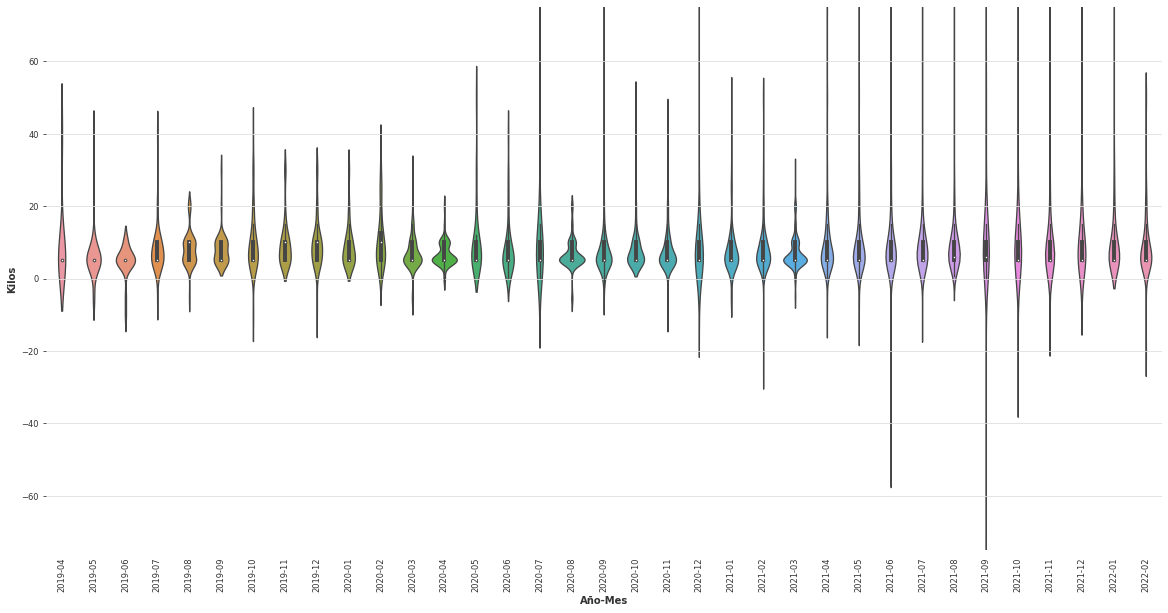

In [161]:
plt.rcParams['figure.figsize'] =(20,10)
sns.violinplot(data = df, x='Año-Mes', y='Kilos')
plt.xticks(rotation=90)
plt.ylim(-75,75)

In [162]:
plt.rcParams['figure.figsize'] =(20,10)
sns.boxplot(data = df, x='Año-Mes', y='Kilos', orient='v')
plt.xticks(rotation=90)
plt.ylim(-25,25)

(-25.0, 25.0)

In [ ]:
#Definimos si es outlier o no en base a 3, 4 y 5 desviaciones estándar
df['Kilos_1DV'] = np.where((df.Kilos > (df['mean'] + df['std'])) | (df.Kilos < (df['mean'] - df['std'])), 1, 0)
df['Kilos_2DV'] = np.where((df.Kilos > (df['mean'] + 2*df['std'])) | (df.Kilos < (df['mean'] - 2*df['std'])), 1, 0)
df['Kilos_3DV'] = np.where((df.Kilos > (df['mean'] + 3*df['std'])) | (df.Kilos < (df['mean'] - 3*df['std'])), 1, 0)
df['Kilos_35DV'] = np.where((df.Kilos > (df['mean'] + 3.5*df['std'])) | (df.Kilos < (df['mean'] - 3.5*df['std'])), 1, 0)
df['Kilos_4DV'] = np.where((df.Kilos > (df['mean'] + 4*df['std'])) | (df.Kilos < (df['mean'] - 4*df['std'])), 1, 0)
df['Kilos_5DV'] = np.where((df.Kilos > (df['mean'] + 5*df['std'])) | (df.Kilos < (df['mean'] - 5*df['std'])), 1, 0)
df['Kilos_7DV'] = np.where((df.Kilos > (df['mean'] + 7*df['std'])) | (df.Kilos < (df['mean'] - 7*df['std'])), 1, 0)
df.head()

,Fecha,Kilos,MateriaPrimaChocolate,Año,Semana,Mes,Año-Semana,Año-Mes,mean,std,Kilos_1DV,Kilos_2DV,Kilos_3DV,Kilos_35DV,Kilos_4DV,Kilos_5DV,Kilos_7DV
0,2019-04-01,10.0,AlmendraBitter,2019,14,04,2019-14,2019-04,9.0,11.005049,0,0,0,0,0,0,0
9,2019-04-05,5.0,AlmendraLeche,2019,14,04,2019-14,2019-04,9.0,11.005049,0,0,0,0,0,0,0
7,2019-04-05,5.0,ManíLeche,2019,14,04,2019-14,2019-04,9.0,11.005049,0,0,0,0,0,0,0
6,2019-04-05,5.0,CranberryLeche,2019,14,04,2019-14,2019-04,9.0,11.005049,0,0,0,0,0,0,0
5,2019-04-25,5.0,AlmendraBitter,2019,17,04,2019-17,2019-04,9.0,11.005049,0,0,0,0,0,0,0


In [ ]:
# Mostramos la cantidad de outliers que saca por cada caso
df.sum()

Kilos                                                              62270.8
MateriaPrimaChocolate    AlmendraBitterAlmendraLecheManíLecheCranberryL...
Año                                                               13526507
Año-Semana               2019-142019-142019-142019-142019-172019-142019...
Año-Mes                  2019-042019-042019-042019-042019-042019-042019...
mean                                                               62270.8
std                                                           80481.493161
Kilos_1DV                                                              589
Kilos_2DV                                                              275
Kilos_3DV                                                              133
Kilos_35DV                                                              96
Kilos_4DV                                                               77
Kilos_5DV                                                               36
Kilos_7DV                

## Generamos los dataset con cada caso, cada uno sin outliers según corresponda

In [ ]:
df1dv = df[df['Kilos_1DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df2dv = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df3dv = df[df['Kilos_3DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df35dv = df[df['Kilos_35DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df4dv = df[df['Kilos_4DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df5dv = df[df['Kilos_5DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()
df7dv = df[df['Kilos_7DV'] == 0][['Fecha', 'Año-Mes', 'Kilos']].set_index('Fecha').resample('MS', label='left').sum().reset_index()

df1dv.head()

,Fecha,Kilos
0,2019-04-01,50.0
1,2019-05-01,195.0
2,2019-06-01,90.0
3,2019-07-01,255.0
4,2019-08-01,435.0


In [ ]:
AB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
AB = AB[AB['MateriaPrimaChocolate']=="AlmendraBitter"].resample('MS', label='left').sum().rename(columns= {'Kilos':'AB'})

AL = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
AL = AL[AL['MateriaPrimaChocolate']=="AlmendraLeche"].resample('MS', label='left').sum().rename(columns={'Kilos':'AL'})

CB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
CB = CB[CB['MateriaPrimaChocolate']=="CranberryBitter"].resample('MS', label='left').sum().rename(columns={'Kilos':'CB'})

CL= df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
CL = CL[CL['MateriaPrimaChocolate']=="CranberryLeche"].resample('MS', label='left').sum().rename(columns={'Kilos':'CL'})

MB = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
MB = MB[MB['MateriaPrimaChocolate']=="ManíBitter"].resample('MS', label='left').sum().rename(columns={'Kilos':'MB'})

ML = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Mes', 'Kilos', 'MateriaPrimaChocolate']].set_index('Fecha')
ML = ML[ML['MateriaPrimaChocolate']=="ManíLeche"].resample('MS', label='left').sum().rename(columns={'Kilos':'ML'})

print(AB.shape)
print(AL.shape)
print(CB.shape)
print(CL.shape)
print(MB.shape)
print(ML.shape)

(35, 1)
(35, 1)
(35, 1)
(35, 1)
(35, 1)
(35, 1)


In [ ]:
matrix = pd.concat([AB,AL,CB,CL,MB,ML], axis=1).fillna(0)
matrix['TOTAL'] = matrix['AB']+ matrix['AL']+matrix['CB']+matrix['CL']+matrix['MB']+matrix['ML']
matrix.head()

,AB,AL,CB,CL,MB,ML,TOTAL
Fecha,,,,,,,
2019-04-01,20.0,10.0,5.0,5.0,5.0,5.0,50.0
2019-05-01,40.0,20.0,75.0,35.0,5.0,5.0,180.0
2019-06-01,20.0,65.0,35.0,5.0,0.0,5.0,130.0
2019-07-01,60.0,50.0,55.0,40.0,25.0,60.0,290.0
2019-08-01,125.0,90.0,115.0,35.0,30.0,40.0,435.0


<AxesSubplot:>

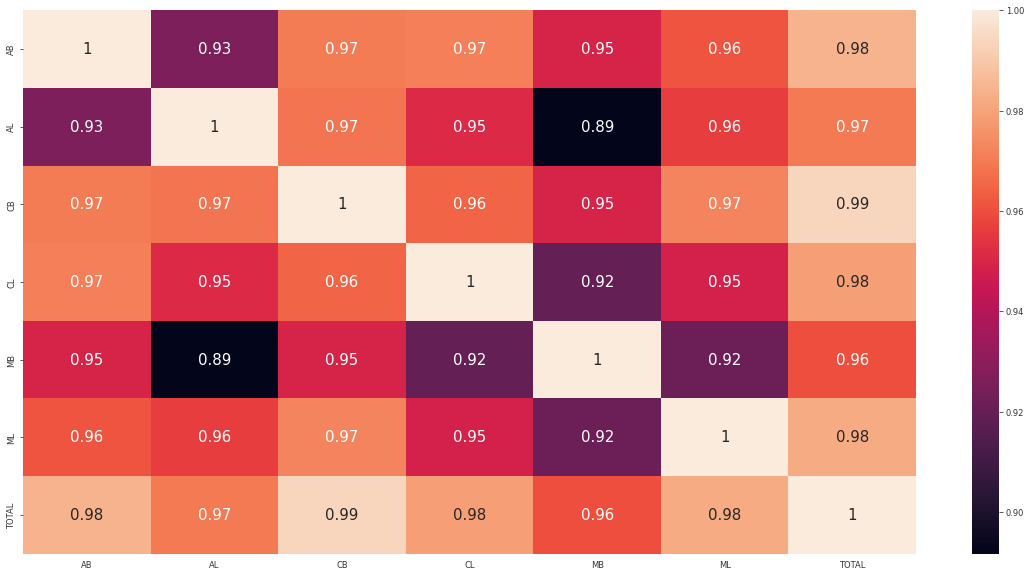

In [ ]:

sns.heatmap(matrix.corr(), annot=True, annot_kws={'size': 15})

# 4) Modeling

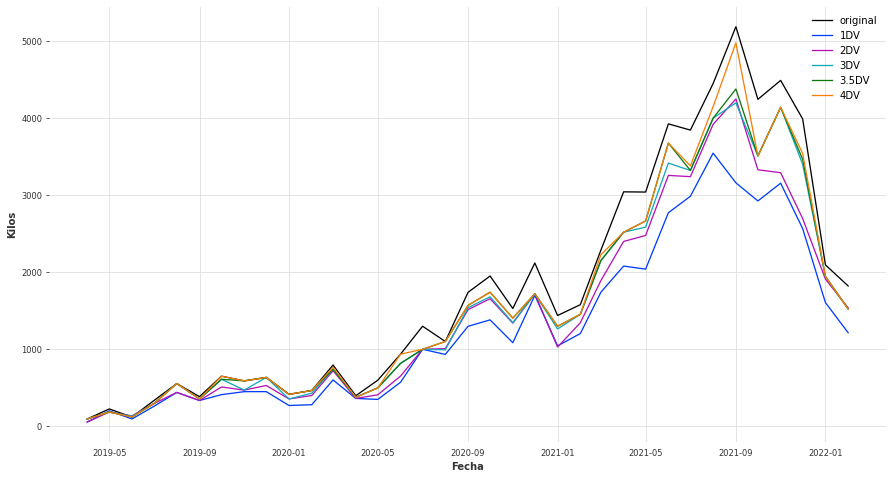

In [ ]:
plt.rcParams['figure.figsize'] =(15,8)
sns.lineplot(data=df.set_index('Fecha').resample("MS", label='left').sum().reset_index(), x="Fecha", y="Kilos", label= 'original')
sns.lineplot(data=df1dv, x="Fecha", y="Kilos", label='1DV')
sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

## Diferenciando

Primero separamos la data entre train y test

In [ ]:
data_real = df2dv[['Kilos']]
largo_train = int(np.round(0.66*len(data_real)))
largo_test = int(len(data_real)-largo_train)

train, test = data_real[:largo_train], data_real[largo_train:]
data_to_diff = train

print(f"shape de data_real {data_real.shape}")
print(f"shape de train {train.shape}")
print(f"shape de test {test.shape}")

shape de data_real (35, 1)
shape de train (23, 1)
shape de test (12, 1)


In [ ]:
#shifting = df.set_index('Fecha').resample("MS", label='left').sum().reset_index()[['Kilos']].shift(1)
print(f"p-value para 0 diff es {adfuller(data_to_diff.dropna())[1]}")
print(f"p-value para 1 diff es {adfuller(data_to_diff.diff().dropna())[1]}")
print(f"p-value para 2 diff es {adfuller(data_to_diff.diff().diff().dropna())[1]}")
print(f"p-value para 3 diff es {adfuller(data_to_diff.diff().diff().diff().dropna())[1]}")
print(f"p-value para 4 diff es {adfuller(data_to_diff.diff().diff().diff().diff().dropna())[1]}")
print(f"p-value para 5 diff es {adfuller(data_to_diff.diff().diff().diff().diff().diff().dropna())[1]}")
print(f"p-value para 6 diff es {adfuller(data_to_diff.diff().diff().diff().diff().diff().diff().dropna())[1]}")
print(f"p-value para 7 diff es {adfuller(data_to_diff.diff().diff().diff().diff().diff().diff().diff().dropna())[1]}")

p-value para 0 diff es 0.6196797476903402
p-value para 1 diff es 0.23879187489537662
p-value para 2 diff es 1.1438957408858617e-08
p-value para 3 diff es 0.23342103102976108
p-value para 4 diff es 0.12805776910480032
p-value para 5 diff es 0.12222111372620326
p-value para 6 diff es 2.7804374684875554e-05
p-value para 7 diff es 6.429122605941031e-07


Notamos que al diferenciar 2 veces, la serie se vuelve prácticamente estacionaria

Valor de $d = 2$

In [ ]:
diff_serie = train.diff().diff().dropna()
diff_serie.shape

(21, 1)

<AxesSubplot:>

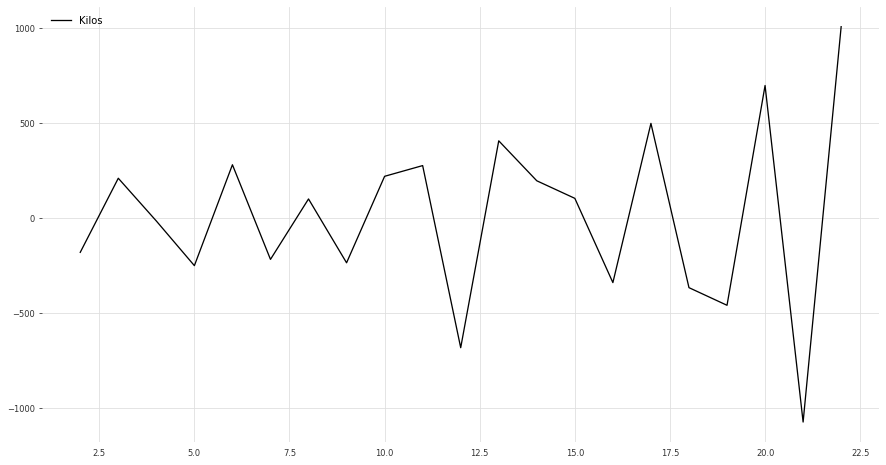

In [ ]:
diff_serie.plot()

Notamos que a simple vista pareciera ser una serie estacionaria

## ACF & PACF

Los gráficos de ACF y PACF se hicieron sobre la serie diferenciada

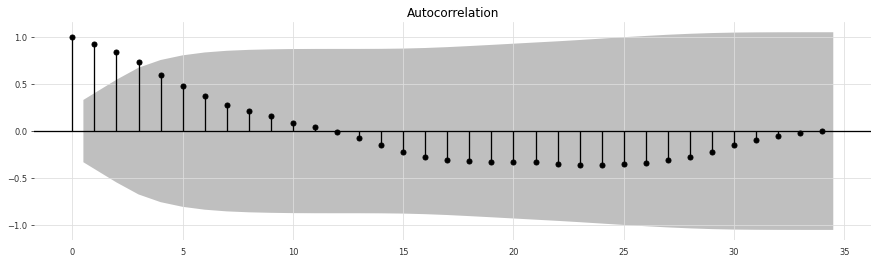

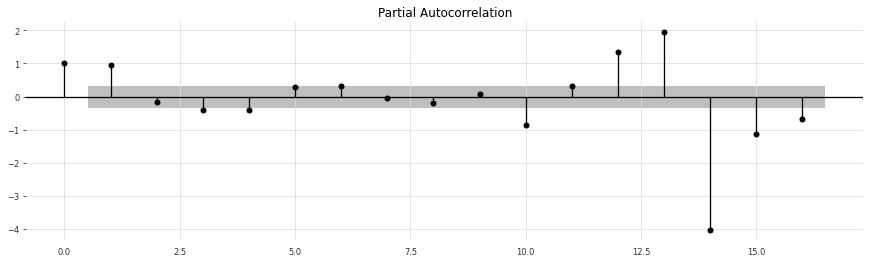

In [ ]:
#ACF y PACF data_real
plt.rcParams['figure.figsize'] =(15,4)
plot_acf(data_real, lags=34);
plot_pacf(data_real, lags=16);

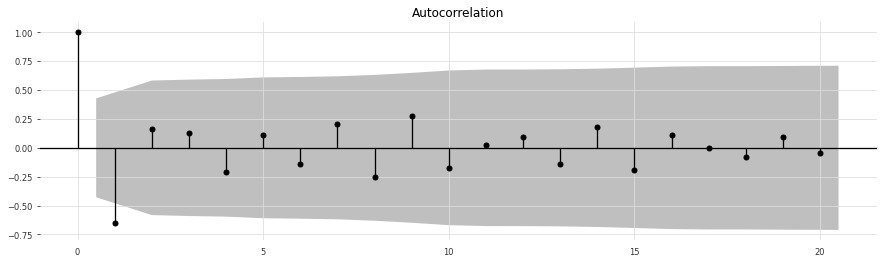

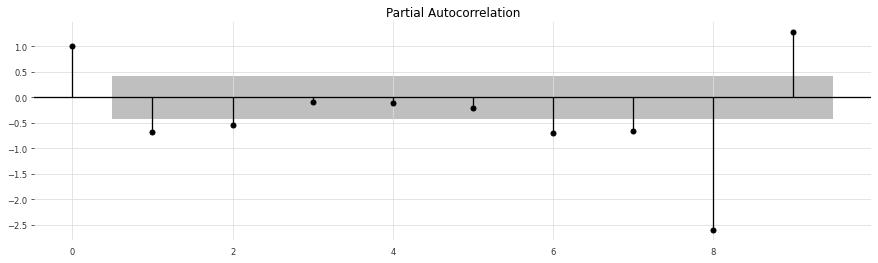

In [ ]:
plt.rcParams['figure.figsize'] =(15,4)
plot_acf(diff_serie, lags=20);
plot_pacf(diff_serie, lags=9);

## ACF:
Las correlaciones disminuyen con el tiempo, y después del lag 1 la señal se apaga.

## PACF:
Para los lags 8 y 9 hay valores muy altos, y antes de ello hay algunos que también son significativos.

## CONCLUSIÓN:
Según lo estudiado, cuando ACF va disminuyendo con el tiempo y los lagos del gráficos de PACF se apagan después de algún lag, esto indicaría que la componente AR debería considerarse, y quizás con una componente de MA(1).

## 

## ARIMA OVER DATAFRAME

In [ ]:
p = range(0,16)
d = range(0,3)
q = range(0,4)
pdq = list(itertools.product(p,d,q))

print(pdq)
print(f"cantidad de combinaciones {len(pdq)}")

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
cantidad de combinaciones 8


In [ ]:
arima_dict = {}
train_size = train.shape[0] # 23
test_size = test.shape[0] # 12
series_arima_size = data_real.shape[0] #35
series_arima = data_real

for j in pdq:
    try:
        rolling_pred = []
        for i in range(train_size, series_arima_size):
            train_for = series_arima[:i] #Comienza desde el index 22 hasta el index 233
            arima_model = ARIMA(train_for, order = j)
            arima_model_fit = arima_model.fit()
            arima_model_preds = arima_model_fit.forecast(steps = 1)
            rolling_pred.append(arima_model_preds.values[0])
            #print(len(train_for))
        rolling = pd.DataFrame(rolling_pred, columns=['ROLLING'])
        rolling.index = [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
        pred = rolling
        error = mean_absolute_percentage_error(data_real[train_size:series_arima_size], pred)
        print(j, error)
    except:
        continue

results = pd.DataFrame.from_dict(arima_dict, orient='index', columns=["mape"]).sort_values(by="mape")
results

(0, 0, 0) 0.5726035402763245
(0, 0, 1) 0.306911130757525
(0, 1, 0) 0.1829096687861532
(0, 1, 1) 0.1919731008470639
(1, 0, 0) 0.18990688171406103
(1, 0, 1) 0.19363546027493383
(1, 1, 0) 0.19520836075325967
(1, 1, 1) 0.19081980341779578


,mape


### ROLLING FORECAST

MAPE: 0.20857233883804904
MAE: 565.4785042000153


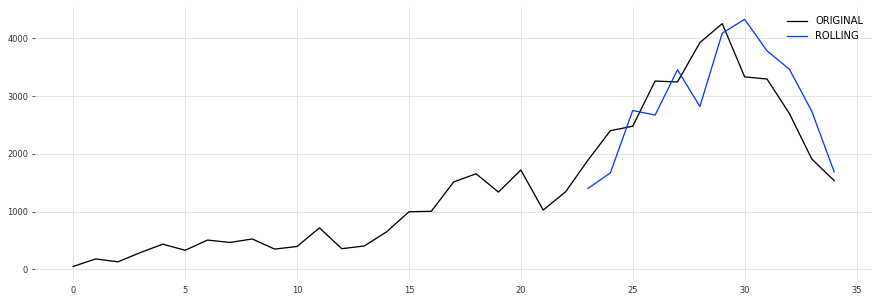

In [85]:
train_size = train.shape[0] # 23
test_size = test.shape[0] # 12
series_arima_size = data_real.shape[0] #35
series_arima = data_real
rolling_pred = []

for i in range(train_size,series_arima_size):
    train_for = series_arima[:i] #Comienza desde el index 22 hasta el index 233
    arima_model = ARIMA(train_for, order = (10, 2, 0))
    arima_model_fit = arima_model.fit()
    arima_model_preds = arima_model_fit.forecast(steps = 1)
    rolling_pred.append(arima_model_preds.values[0])
rolling = pd.DataFrame(rolling_pred, columns=['ROLLING'])
rolling.index = range(train_size,series_arima_size)

pred = rolling
MAPE = mean_absolute_percentage_error(data_real[train_size:series_arima_size], pred)
MAE = mean_absolute_error(data_real[train_size:series_arima_size], pred)
print(f"MAPE: {MAPE}")
print(f"MAE: {MAE}")

fig, ax = plt.subplots(figsize= (15,5))

data_real.rename(columns={'Kilos':'ORIGINAL'}).plot(label="original", ax=ax)
pred.plot(label="pred", ax=ax)
plt.legend()

In [ ]:
train_size = train.shape[0] # 23
test_size = test.shape[0] # 12
series_arima_size = data_real.shape[0] #35
series_arima = data_real
rolling_pred = []

for i in range(train_size,series_arima_size):
    train_for = series_arima[:i] #Comienza desde el index 22 hasta el index 233
    arima_model = ARIMA(train_for, order = (10, 2, 0))
    arima_model_fit = arima_model.fit()
    arima_model_preds = arima_model_fit.forecast(steps = 1)
    rolling_pred.append(arima_model_preds.values[0])
rolling = pd.DataFrame(rolling_pred, columns=['ROLLING'])
rolling.index = range(train_size,series_arima_size)

pred = rolling
MAPE = mean_absolute_percentage_error(data_real[train_size:series_arima_size], pred)
MAE = mean_absolute_error(data_real[train_size:series_arima_size], pred)
print(f"MAPE: {MAPE}")
print(f"MAE: {MAE}")

fig, ax = plt.subplots(figsize= (15,5))

data_real.rename(columns={'Kilos':'ORIGINAL'}).plot(label="original", ax=ax)
pred.plot(label="pred", ax=ax)
plt.legend()

In [ ]:
train_size = train.shape[0] # 23
test_size = test.shape[0] # 12
series_arima_size = data_real.shape[0] #35
series_arima = data_real
rolling_pred = []

for i in range(train_size,series_arima_size):
    train_for = series_arima[:i] #Comienza desde el index 22 hasta el index 233
    arima_model = ARIMA(train_for, order = (10, 2, 0))
    arima_model_fit = arima_model.fit()
    arima_model_preds = arima_model_fit.forecast(steps = 1)
    rolling_pred.append(arima_model_preds.values[0])
rolling = pd.DataFrame(rolling_pred, columns=['ROLLING'])
rolling.index = range(train_size,series_arima_size)

pred = rolling
MAPE = mean_absolute_percentage_error(data_real[train_size:series_arima_size], pred)
MAE = mean_absolute_error(data_real[train_size:series_arima_size], pred)
print(f"MAPE: {MAPE}")
print(f"MAE: {MAE}")

fig, ax = plt.subplots(figsize= (15,5))

data_real.rename(columns={'Kilos':'ORIGINAL'}).plot(label="original", ax=ax)
pred.plot(label="pred", ax=ax)
plt.legend()

In [251]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Kilos   No. Observations:                   23
Model:                ARIMA(10, 2, 0)   Log Likelihood                -149.723
Date:                Thu, 17 Mar 2022   AIC                            321.447
Time:                        13:55:49   BIC                            332.936
Sample:                             0   HQIC                           323.940
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0192      0.258     -3.954      0.000      -1.524      -0.514
ar.L2         -0.8131      0.387     -2.103      0.036      -1.571      -0.055
ar.L3         -0.2125      0.368     -0.577      0.564      -0.934       0.509
ar.L4         -0.7285      0.336     -2.169      0.030      -1.387      -0.070
ar.L5         -0.8212      0.464     -1.772      0.076      -1.730       0.087
ar.L6         -1.2307      0.286     -4.300      0.000      -1.792      -0.670
ar.L7         -0.6918      0.341     -2.028      0.043      -1.360      -0.023
ar.L8         -0.5522      0.741     -0.745      0.456      -2.004       0.900
ar.L9         -0.1344      1.105     -0.122      0.903      -2.300       2.031
ar.L10        -0.3093      0.829     -0.373      0.709      -1.935       1.316
sigma2      2.441e+04   9559.600      2.554      0.011    5678.421    4.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.45   Prob(JB):                         0.56
Heteroskedasticity (H):              10.58   Skew:                             0.57
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Seasonal Decompose

In [95]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
from darts.metrics import mape, mae
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose
#data= shifting
#data= df.set_index('Fecha').resample("MS", label='left').sum().reset_index()[['Kilos']]
data = df2dv[['Kilos']]
data.head()

,Kilos
0,717.0
1,357.0
2,404.0
3,647.6
4,995.4


In [97]:
residuals_abs_sum = {}
residuals_abs_mean = {}

for i in range(1,13):
    ts_dicomposition = seasonal_decompose(x=data, model='additive', period=i, two_sided=True, extrapolate_trend=2)
    residual_estimate = ts_dicomposition.resid
    residuals_abs_sum[i] = residual_estimate.sum()
    residuals_abs_mean[i] = residual_estimate.mean()

pd.merge(
    pd.DataFrame.from_dict(residuals_abs_sum, orient='index', columns=["sum_residuals"]),
    pd.DataFrame.from_dict(residuals_abs_mean, orient='index', columns=["mean_residuals"]), left_index=True, right_index=True
).sort_values(by="mean_residuals")

,sum_residuals,mean_residuals
8,-3201.266667,-133.386111
6,-1950.300000,-81.262500
10,-1848.453333,-77.018889
9,-1316.322634,-54.846776
7,-1199.685714,-49.986905
11,-1190.852893,-49.618871
12,-891.037500,-37.126562
5,-545.792000,-22.741333
4,-370.483333,-15.436806
1,0.000000,0.000000


residual mean = 281.59609374999974


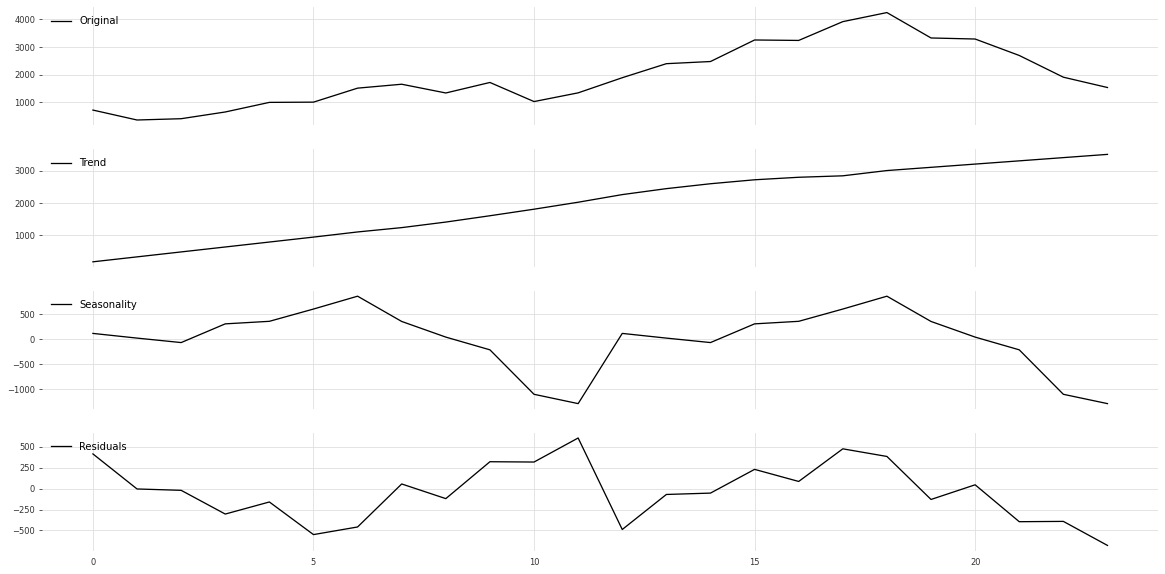

In [98]:
ts_dicomposition_a = seasonal_decompose(x=data, model='additive', period=3, two_sided=True, extrapolate_trend=2)
trend_estimate_a = ts_dicomposition.trend
seasonal_estimate_a = ts_dicomposition.seasonal
residual_estimate_a = ts_dicomposition.resid

print(f"residual mean = {np.abs(residual_estimate).mean()}")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(data, label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_a, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_a, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_a, label='Residuals')
axes[3].legend(loc='upper left');

In [99]:
residuals_abs_mean = {}
residuals_abs_max = {}
residuals_abs_min = {}

for i in range(2,13):
    ts_dicomposition = seasonal_decompose(x=data, model='multiplicative', period=i, two_sided=True, extrapolate_trend=2)
    residual_estimate = ts_dicomposition.resid
    residuals_abs_mean[i] = residual_estimate.mean()
    residuals_abs_max[i] = residual_estimate.max()
    residuals_abs_min[i] = residual_estimate.min()

pd.merge(pd.merge(
    pd.DataFrame.from_dict(residuals_abs_mean, orient='index', columns=["mean_residuals"]),
    pd.DataFrame.from_dict(residuals_abs_min, orient='index', columns=["min_residuals"]),
    left_index=True, right_index=True),
    pd.DataFrame.from_dict(residuals_abs_max, orient='index', columns=["max_residuals"]),
    left_index=True, right_index=True
).sort_values(by="mean_residuals")

,mean_residuals,min_residuals,max_residuals
8,0.951998,0.441224,1.490800
9,0.966693,0.581241,1.431286
10,0.974982,0.541502,1.352104
11,0.977738,0.622204,1.541825
7,0.978102,0.623466,1.461093
5,1.016635,0.591326,1.969098
3,1.022678,0.784587,1.717197
2,1.032967,0.766421,2.182832
6,1.047970,0.605786,2.099742
4,1.066077,0.683017,2.558841


In [100]:
ts_dicomposition_m = seasonal_decompose(x=data, model='multiplicative', period=11, two_sided=True, extrapolate_trend=2)
trend_estimate_m = ts_dicomposition.trend
seasonal_estimate_m = ts_dicomposition.seasonal
residual_estimate_m = ts_dicomposition.resid

np.abs(residual_estimate).mean()

1.1174123331472294

residual mean = 1.1174123331472294


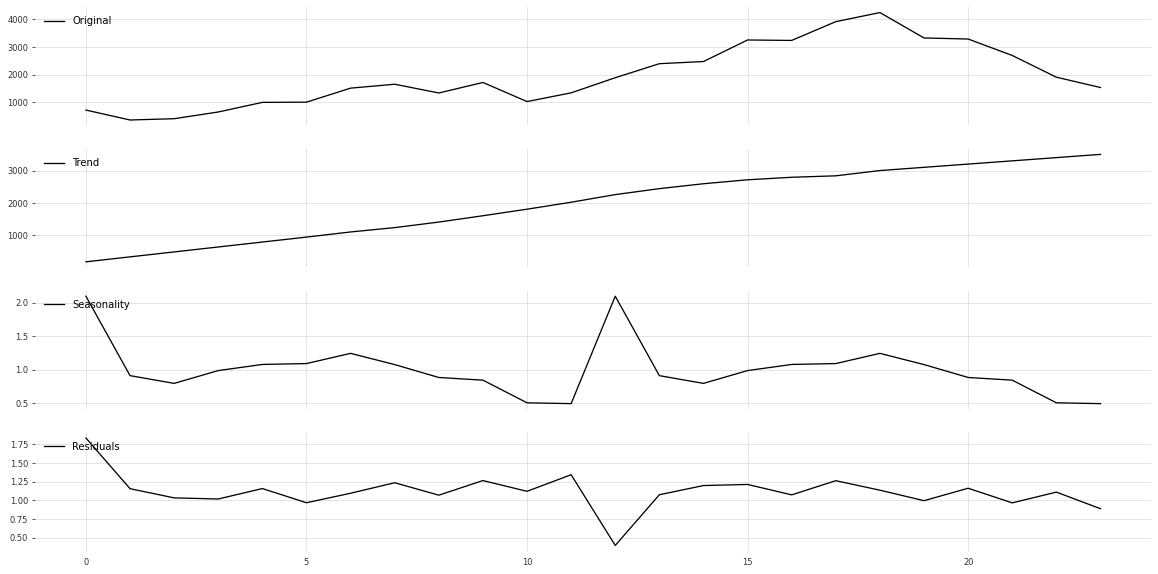

In [101]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

print(f"residual mean = {np.abs(residual_estimate).mean()}")

# First plot to the Original time series
axes[0].plot(data, label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_m, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_m, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_m, label='Residuals')
axes[3].legend(loc='upper left');

## ARIMA  - SEASONAL_ESTIMATE_A

In [102]:
ts = seasonal_estimate_a
print(ts.head())
print(ts.shape)

0    116.571701
1     22.623785
2    -66.715799
3    307.886285
4    358.721701
Name: seasonal, dtype: float64
(24,)


In [103]:
adftest = adfuller(ts)
print(f"pvalue de adfuller es: {adftest[1]}")

pvalue de adfuller es: 0.00014604362815840596


Es menor a 0.05, por tanto la serie es estacionaria bajo el test de Augmented Dickey-Fulled

In [104]:
print(f"Largo de la serie es: {len(ts)}, y el 0.8*LargoSerie es {0.8*len(ts)}")
train, test = ts[:19], ts[19:]
print(f"Largo de TRAIN: {len(train)}. Largo de TEST: {len(test)}")

Largo de la serie es: 24, y el 0.8*LargoSerie es 19.200000000000003
Largo de TRAIN: 19. Largo de TEST: 5


In [105]:
p = range(0,6)
d = range(0,1)
q = range(0,6)


pdq = list(itertools.product(p,d,q))
print(len(pdq))
print(pdq)

36
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 0, 5), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 0, 3), (5, 0, 4), (5, 0, 5)]


In [106]:
diccionarioo = {}

for i in pdq:
        try:
                model=sm.tsa.statespace.SARIMAX(train, order = (0,0,0), seasonal_order= i+(12,) ).fit()
                pred=model.predict(start=len(train), end=(len(ts)-1))
                error=mean_absolute_percentage_error(test, pred)
                print(i, error)
                diccionarioo[str(i)]=error
        except:
                continue


results = pd.DataFrame.from_dict(diccionarioo, orient='index', columns=["mape"]).sort_values(by="mape")
results

(0, 0, 0) 1.0
(0, 0, 1) 0.500027292208334
(0, 0, 2) 0.29289335771441133
(0, 0, 3) 0.19098342391530482
(0, 0, 4) 0.13397921475301172
(0, 0, 5) 0.09909972771769845
(1, 0, 0) 0.0004383468454859516
(1, 0, 1) 1.0437852919864908e-05
(1, 0, 2) 3.7943908183617976e-05
(1, 0, 3) 0.2931091319111077
(1, 0, 4) 0.1910586730781608
(1, 0, 5) 25.62660854032456
(2, 0, 0) 0.00030930651853794156
(2, 0, 1) 1.7998074801589252e-05
(2, 0, 2) 0.06541098581450988
(2, 0, 3) 0.004184259889868281
(2, 0, 4) 0.29253812847304583
(2, 0, 5) 0.00014327755771172536
(3, 0, 0) 0.0002134647906773866
(3, 0, 1) 1.3305783758389114e-05
(3, 0, 2) 0.0005447060002407098
(3, 0, 4) 0.014431779898295785
(3, 0, 5) 4.425061454619661e-05
(4, 0, 1) 5.253187526308229e-05
(4, 0, 2) 0.005666475943748256
(4, 0, 3) 4.9658540007498595e-05
(4, 0, 4) 0.00014180529440610887
(4, 0, 5) 2.1443022595039613e-05
(5, 0, 0) 6.190712287423503e-05
(5, 0, 1) 6.848351862521814e-05
(5, 0, 4) 2.5709159390813256e-05


,mape
"(1, 0, 1)",0.000010
"(3, 0, 1)",0.000013
"(2, 0, 1)",0.000018
"(4, 0, 5)",0.000021
"(5, 0, 4)",0.000026
"(1, 0, 2)",0.000038
"(3, 0, 5)",0.000044
"(4, 0, 3)",0.000050
"(4, 0, 1)",0.000053
"(5, 0, 0)",0.000062


In [107]:
model=sm.tsa.statespace.SARIMAX(train, order = (0,0,0), seasonal_order= (1,0,1) +(12,) ).fit()
forecast=model.predict(start=len(train), end=(len(ts)-1))

MAPE: 1.0437852919864908e-05


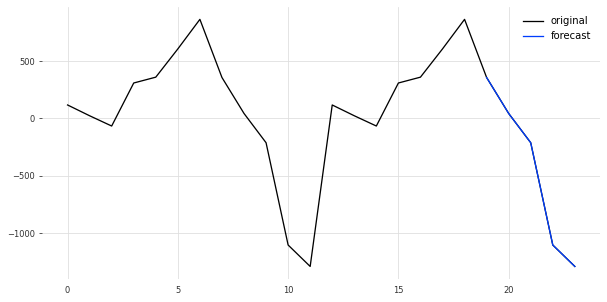

In [108]:
print(f"MAPE: {mean_absolute_percentage_error(test, forecast)}")
plt.subplots(figsize=(10,5))
ts.plot(label='original')
forecast.plot(label='forecast')
plt.legend()

### Regresión Lineal - TREND_ESTIMATE_A

In [109]:
trend_estimate_a.dropna()

0      186.051389
1      338.638889
2      491.226389
3      643.813889
4      796.401389
5      948.988889
6     1107.825000
7     1241.666667
8     1413.000000
9     1608.000000
10    1810.208333
11    2025.258333
12    2260.858333
13    2444.766667
14    2596.058333
15    2718.266667
16    2795.808333
17    2840.658333
18    3003.002778
19    3102.877778
20    3202.752778
21    3302.627778
22    3402.502778
23    3502.377778
Name: trend, dtype: float64

In [110]:
a= min(trend_estimate_a.dropna().index)
b= max(trend_estimate_a.dropna().index) +1
c= len(ts) #min_index, max_index de la SerieAnterior +1, max

pendiente, intercepto = np.polyfit(list(range(a,b)),trend_estimate_a.dropna(), deg=1 )
(pendiente, intercepto)

(151.34758152173913, 250.4877083333335)

In [111]:
forecast_trend = [x*pendiente + intercepto for x in list(range(a,b))]
forecast_trend = pd.DataFrame(forecast_trend, index=list(range(a,b)), columns=['polyfit-2'])
forecast_trend

,polyfit-2
0,250.487708
1,401.835290
2,553.182871
3,704.530453
4,855.878034
5,1007.225616
6,1158.573197
7,1309.920779
8,1461.268361
9,1612.615942


MAPE: 0.07050466868735498


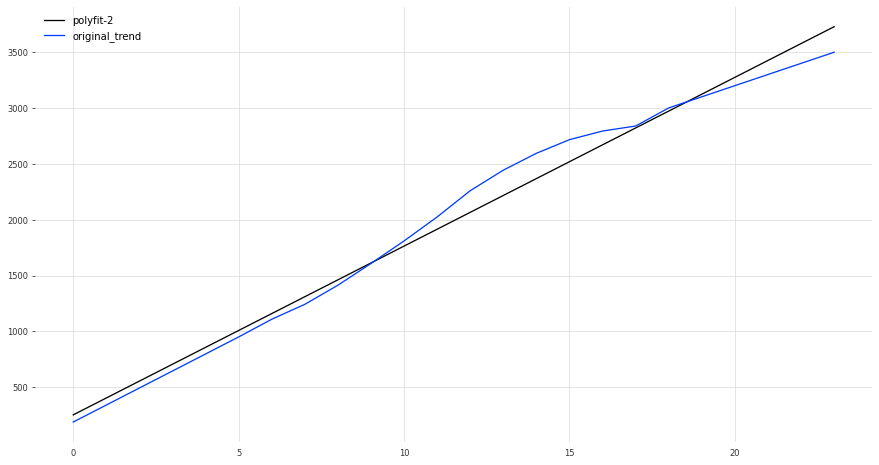

In [112]:
print(f"MAPE: {mean_absolute_percentage_error(trend_estimate_a.dropna(), forecast_trend)}")
forecast_trend.plot(label="forecast_trend")
trend_estimate_a.plot(label="original_trend")
plt.legend()

### UNIMOS AMBAS PARTES - MODELO ADDITIVE

In [113]:
#Parte TREND del mes 5 al mes 20
forecast_trend_20 = [x*pendiente + intercepto for x in list(range(a,c))]
forecast_trend_20 = pd.DataFrame(forecast_trend_20, index=list(range(a,c)), columns=['polyfit-2'])

#Parte SEASON del mes 5 al mes 20
season_estimate_a_20 = pd.DataFrame(seasonal_estimate_a[a:c]).rename(columns={'seasonal':'season_estimate_a_20'})

#Parte ORIGINAL
data_real = data[a:c]

#UNION
first_shot = pd.concat([forecast_trend_20, season_estimate_a_20, data_real],axis=1)
first_shot['forecast_first_shot'] = first_shot['polyfit-2'] + first_shot['season_estimate_a_20']
first_shot


,polyfit-2,season_estimate_a_20,Kilos,forecast_first_shot
0,250.487708,116.571701,717.0,367.059410
1,401.835290,22.623785,357.0,424.459075
2,553.182871,-66.715799,404.0,486.467073
3,704.530453,307.886285,647.6,1012.416738
4,855.878034,358.721701,995.4,1214.599736
5,1007.225616,604.602951,1004.0,1611.828567
6,1158.573197,862.012674,1511.4,2020.585871
7,1309.920779,355.854340,1653.0,1665.775119
8,1461.268361,42.750174,1336.0,1504.018534
9,1612.615942,-212.187326,1717.0,1400.428616


MAPE FIRST SHOT: 0.25237288160906074


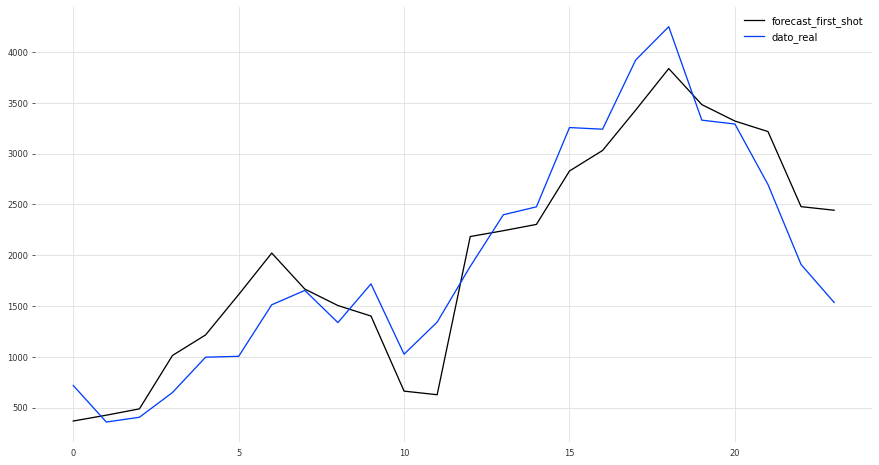

In [114]:
print(f"MAPE FIRST SHOT: {mean_absolute_percentage_error(first_shot['forecast_first_shot'], first_shot['Kilos'])}")

first_shot['forecast_first_shot'].plot(label="forecast_first_shot")
first_shot['Kilos'].plot(label="dato_real")
plt.legend()

## ARIMA  - SEASONAL_ESTIMATE_M

In [115]:
ts_m = seasonal_estimate_m
print(ts.head())
print(ts.shape)

0    116.571701
1     22.623785
2    -66.715799
3    307.886285
4    358.721701
Name: seasonal, dtype: float64
(24,)


In [116]:
adftest_m = adfuller(ts_m)
print(f"pvalue de adfuller es: {adftest[1]}")

pvalue de adfuller es: 0.00014604362815840596


menor a 0.05, es estacionaria

In [117]:
print(f"Largo de la serie es: {len(ts_m)}, y el 0.8*LargoSerie es {0.8*len(ts_m)}")
train_m, test_m = ts_m[:19], ts_m[19:]
print(f"Largo de TRAIN: {len(train_m)}. Largo de TEST: {len(test_m)}")

Largo de la serie es: 24, y el 0.8*LargoSerie es 19.200000000000003
Largo de TRAIN: 19. Largo de TEST: 5


In [118]:
p = range(0,2)
d = range(0,2)
q = range(0,8)


pdq = list(itertools.product(p,d,q))
print(len(pdq))
print(pdq)

128
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 0, 6), (2, 0, 7), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 1, 6), (2, 1, 7), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (3, 0, 6), (3, 0, 7), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 1, 6), (3, 1, 7), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 0, 5), (4, 0, 6), (4, 0, 7), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 1, 6), (4, 1, 7), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 0, 3), (5, 0, 4), (5, 0, 5), (5, 0, 6), (5, 0, 7), (5, 1, 0), (5, 1, 1), (5, 1

In [119]:
diccionarioo_m = {}

for i in pdq:
        try:
                model=sm.tsa.statespace.SARIMAX(train_m, order = (0,0,0), seasonal_order= i + (6,) ).fit()
                pred_m=model.predict(start=len(train_m), end=(len(ts_m)-1))
                error=mean_absolute_percentage_error(test_m, pred_m)
                print(i, error)
                diccionarioo_m[str(i)]=error
        except:
                continue


results = pd.DataFrame.from_dict(diccionarioo_m, orient='index', columns=["mape"]).sort_values(by="mape")
results

(0, 0, 0) 1.0
(0, 0, 1) 0.5204427920988751
(0, 0, 2) 0.468746625041072
(0, 0, 3) 0.25664428939213574
(0, 0, 4) 0.26812800479073984
(0, 0, 5) 0.1678489082379157
(0, 0, 6) 0.1791112413441093
(0, 0, 7) 0.12906852708471087
(0, 1, 0) 0.555448076779106
(0, 1, 1) 0.3702987088078064
(0, 1, 2) 0.23405074905368561
(0, 1, 3) 0.16335083885212845
(0, 1, 4) 0.11990804749660233
(0, 1, 5) 0.0915524631464808
(0, 1, 6) 0.0722536401136205
(0, 1, 7) 0.0584648638907452
(1, 0, 0) 0.47287962982429355
(1, 0, 1) 0.35499719181601613
(1, 0, 2) 0.2268008152579571
(1, 0, 3) 0.16101626376551206
(1, 0, 4) 0.11807039656375418
(1, 0, 5) 0.09075495597868687
(1, 0, 6) 0.0714634789227622
(1, 0, 7) 0.058334425748357996
(1, 1, 0) 0.5554481126475863
(1, 1, 1) 0.0004272115890138371
(1, 1, 2) 0.0002596113277679563
(1, 1, 3) 9.535176123808464e-05
(1, 1, 4) 0.00011785384588155413
(1, 1, 5) 0.00031801736963703845
(1, 1, 6) 0.00014049009731747898
(1, 1, 7) 0.00024982677337385284
(2, 0, 0) 0.002076623364219891
(2, 0, 1) 0.00080694

In [ ]:
model_m=sm.tsa.statespace.SARIMAX(train_m, order = (0,0,0), seasonal_order= (6,1,1) +(6,) ).fit()
forecast_m=model_m.predict(start=len(train_m), end=(len(ts_m)-1))

MAPE: 2.5287558589358054e-06


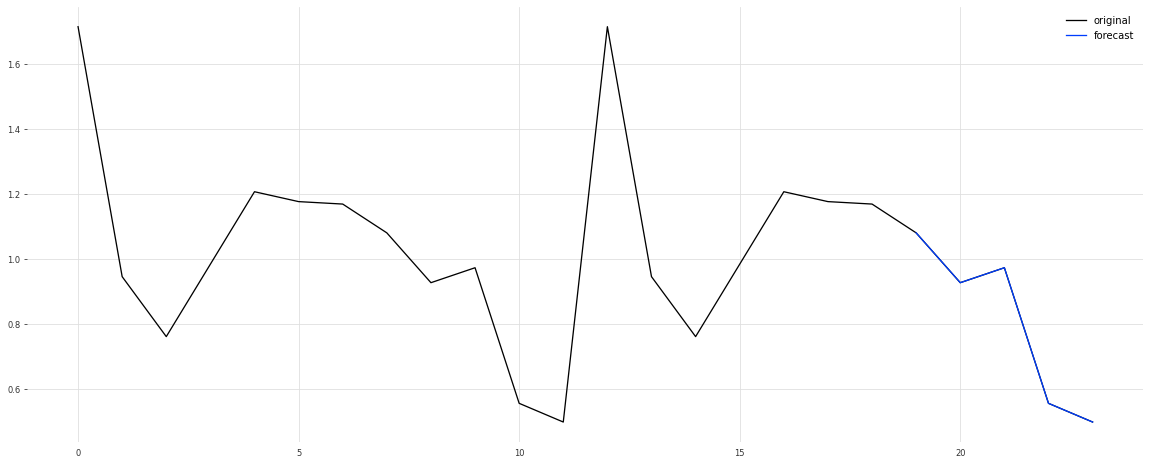

In [ ]:
print(f"MAPE: {mean_absolute_percentage_error(test_m, forecast_m)}")
plt.subplots(figsize=(20,8))
ts_m.plot(label='original')
forecast_m.plot(label='forecast')
plt.legend()

### Regresión Lineal - TREND_ESTIMATE_M

In [ ]:
trend_estimate_m.dropna()

0      216.072222
1      346.788889
2      477.505556
3      608.222222
4      738.938889
5      869.655556
6     1004.216667
7     1123.400000
8     1265.650000
9     1428.025000
10    1602.733333
11    1794.658333
12    1981.375000
13    2123.483333
14    2274.316667
15    2396.900000
16    2456.525000
17    2480.441667
18    2649.226389
19    2740.330556
20    2831.434722
21    2922.538889
22    3013.643056
23    3104.747222
Name: trend, dtype: float64

In [ ]:
a= min(trend_estimate_m.dropna().index)
b= max(trend_estimate_m.dropna().index) +1
c= len(ts_m) #min_index, max_index de la SerieAnterior +1, max

pendiente_m, intercepto_m = np.polyfit(list(range(a,b)),trend_estimate_m.dropna(), deg=1 )
(pendiente_m, intercepto_m)

(131.2977300724638, 258.8606527777768)

In [ ]:
forecast_trend_m = [x*pendiente_m + intercepto_m for x in list(range(a,b))]
forecast_trend_m = pd.DataFrame(forecast_trend_m, index=list(range(a,b)), columns=['polyfit-2_m'])
forecast_trend_m

,polyfit-2_m
0,258.860653
1,390.158383
2,521.456113
3,652.753843
4,784.051573
5,915.349303
6,1046.647033
7,1177.944763
8,1309.242493
9,1440.540223


MAPE: 0.05470521657723861


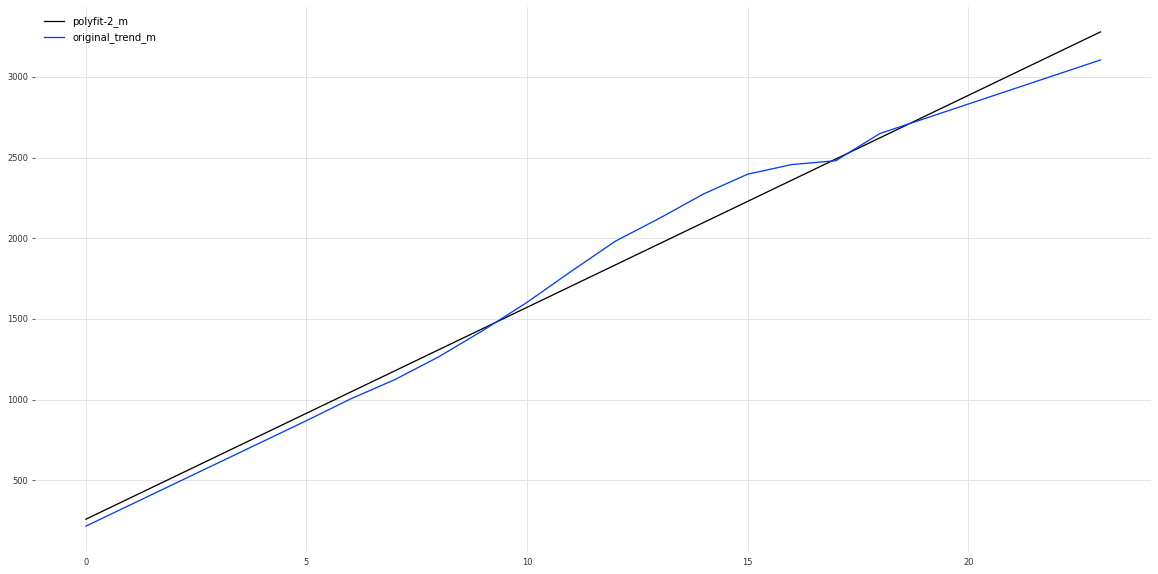

In [ ]:
print(f"MAPE: {mean_absolute_percentage_error(trend_estimate_m.dropna(), forecast_trend_m)}")
forecast_trend_m.plot(label="forecast_trend_m")
trend_estimate_m.plot(label="original_trend_m")
plt.legend()

### UNIMOS AMBAS PARTES - MODELO MULTIPLICATIVE

In [ ]:
#Parte TREND del mes a al mes c
forecast_trend_20_m = [x*pendiente_m + intercepto_m for x in list(range(a,c))]
forecast_trend_20_m = pd.DataFrame(forecast_trend_20_m, index=list(range(a,c)), columns=['polyfit-2_m'])

#Parte SEASON del mes 5 al mes 20
season_estimate_a_20_m = pd.DataFrame(seasonal_estimate_m[a:c]).rename(columns={'seasonal':'season_estimate_a_20_m'})

#Parte ORIGINAL
data_real = data[a:c]

#UNION
second_shot = pd.concat([forecast_trend_20_m, season_estimate_a_20_m, data_real],axis=1)
second_shot['forecast_second_shot'] = second_shot['polyfit-2_m']*second_shot['season_estimate_a_20_m']
second_shot

,polyfit-2_m,season_estimate_a_20_m,Kilos,forecast_second_shot
0,258.860653,1.715318,597.0,444.028307
1,390.158383,0.946228,357.0,369.178634
2,521.456113,0.761758,344.0,397.223321
3,652.753843,0.984659,567.6,642.739924
4,784.051573,1.207536,995.4,946.770671
5,915.349303,1.177121,929.0,1077.476977
6,1046.647033,1.169581,1294.6,1224.138532
7,1177.944763,1.080976,1378.0,1273.330336
8,1309.242493,0.927678,1081.0,1214.554829
9,1440.540223,0.973691,1697.0,1402.641192


MAPE SECOND SHOT: 0.16400563674974084


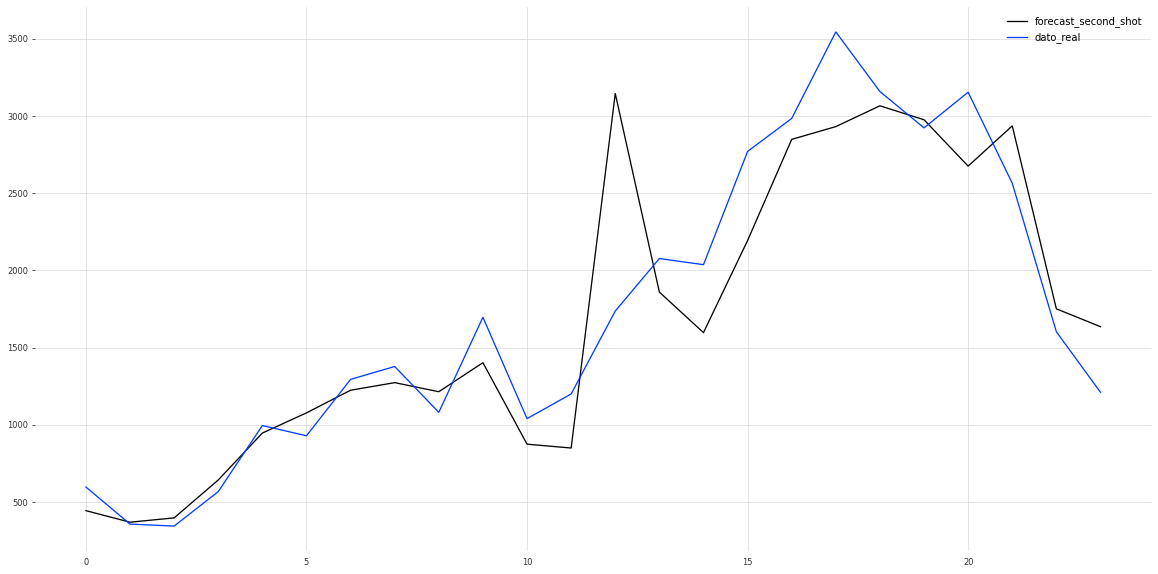

In [ ]:
print(f"MAPE SECOND SHOT: {mean_absolute_percentage_error(second_shot['forecast_second_shot'], second_shot['Kilos'])}")

second_shot['forecast_second_shot'].plot(label="forecast_second_shot")
second_shot['Kilos'].plot(label="dato_real")
plt.legend()

## ARIMAX (integrando la cantidad de casos nuevos covid-19 mensuales RM a SARIMAX)

,casos
fecha,
2020-03-01,2738
2020-04-01,13285
2020-05-01,83665
2020-06-01,148283
2020-07-01,76144
2020-08-01,56049
2020-09-01,51171
2020-10-01,47143
2020-11-01,41487
